# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [130]:
import pandas as pd
import numpy as np

---
## 2. Load data

In [131]:
df = pd.read_csv('/content/clean_data_after_era.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [132]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,var_3m_price_off_peak_var,var_3m_price_peak_var,var_3m_price_mid_peak_var,var_3m_price_off_peak_fix,var_3m_price_peak_fix,var_3m_price_mid_peak_fix,var_6m_price_off_peak_y,var_6m_price_peak_y,var_6m_price_mid_peak_y,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2016-06-15,2016-06-15,...,0.000408,0.000102,0.002725,6.258881,298.59155,132.707382,6.259289,298.591652,132.710106,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2016-08-30,2016-08-30,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2016-04-16,2016-04-16,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [133]:
price_df = pd.read_csv('/content/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [134]:
# Group off-peak prices by companies and month

monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()
# print(monthly_price_by_id.head())
# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
#Merge the december and januaray prices, rename the columns in december df, drop the price date column
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
#calculate price difference for energy
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
#calculate price difference for power
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
#get the difference df
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


`df.agg`: DataFrame.agg(func=None, axis=0, *args, **kwargs)
Aggregate using one or more operations over the specified axis. [ref](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html)

*Here is used to obtain the mean value for each id's pricedate*

`df.reset_index`:Reset the index, or a level of it. Reset the index of the DataFrame, and use the default one instead. If the DataFrame has a MultiIndex, this method can remove one or more levels. [ref](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html)

*Here is used to set id as a coloumn and add a default index column.*

In [135]:
#add the preprocessed feature: jan_dec_price_diff to the preprocessed dataset.
df = pd.merge(df, diff, on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,var_3m_price_mid_peak_var,var_3m_price_off_peak_fix,var_3m_price_peak_fix,var_3m_price_mid_peak_fix,var_6m_price_off_peak_y,var_6m_price_peak_y,var_6m_price_mid_peak_y,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2016-06-15,2016-06-15,...,0.002725,6.258881,298.59155,132.707382,6.259289,298.591652,132.710106,1,0.020057,3.700961
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2016-08-30,2016-08-30,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,-0.003767,0.177779
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2016-04-16,2016-04-16,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,-0.004670,0.177779
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2016-03-30,2016-03-30,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,-0.004547,0.177779
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2016-03-07,2016-03-07,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,-0.006192,0.162916


In [136]:
#Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var':'mean',
    'price_mid_peak_var':'mean',
    'price_off_peak_fix':'mean',
    'price_peak_fix':'mean',
    'price_mid_peak_fix':'mean'
}).reset_index()
mean_prices.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000


In [137]:
#Calculate the mean difference between consecutive periods

mean_prices['off_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_var_mean_ diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_mid_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_mid_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [138]:
columns = [
    'id',
    'off_peak_var_mean_diff',
    'peak_mid_var_mean_ diff',
    'off_mid_var_mean_diff',
    'off_peak_fix_mean_diff',
    'peak_mid_fix_mean_diff',
    'off_mid_fix_mean_diff'
]

df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,var_6m_price_mid_peak_y,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_var_mean_diff,peak_mid_var_mean_ diff,off_mid_var_mean_diff,off_peak_fix_mean_diff,peak_mid_fix_mean_diff,off_mid_fix_mean_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2016-06-15,2016-06-15,...,132.710106,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2016-08-30,2016-08-30,...,0.000000,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2016-04-16,2016-04-16,...,0.000000,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2016-03-30,2016-03-30,...,0.000000,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2016-03-07,2016-03-07,...,0.000000,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


In [139]:
#Aggregate average prices per period by month by company

mean_prices_by_mo = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var':'mean',
    'price_mid_peak_var':'mean',
    'price_off_peak_fix':'mean',
    'price_peak_fix':'mean',
    'price_mid_peak_fix':'mean'
}).reset_index()

In [140]:
#Calculate the mean difference between consecutive periods  by month

mean_prices_by_mo['off_peak_var_mean_diff'] = mean_prices_by_mo['price_off_peak_var'] - mean_prices_by_mo['price_peak_var']
mean_prices_by_mo['peak_mid_var_mean_ diff'] = mean_prices_by_mo['price_peak_var'] - mean_prices_by_mo['price_mid_peak_var']
mean_prices_by_mo['off_mid_var_mean_diff'] = mean_prices_by_mo['price_off_peak_var'] - mean_prices_by_mo['price_mid_peak_var']
mean_prices_by_mo['off_peak_fix_mean_diff'] = mean_prices_by_mo['price_off_peak_fix'] - mean_prices_by_mo['price_peak_fix']
mean_prices_by_mo['peak_mid_fix_mean_diff'] = mean_prices_by_mo['price_peak_fix'] - mean_prices_by_mo['price_mid_peak_fix']
mean_prices_by_mo['off_mid_fix_mean_diff'] = mean_prices_by_mo['price_off_peak_fix'] - mean_prices_by_mo['price_mid_peak_fix']

In [141]:
#Calculate the maximum monthly difference across time periods
max_diff_acr_periods_mo = mean_prices_by_mo.groupby(['id']).agg({
    'off_peak_var_mean_diff': 'max',
    'peak_mid_var_mean_ diff':'max',
    'off_mid_var_mean_diff':'max',
    'off_peak_fix_mean_diff':'max',
    'peak_mid_fix_mean_diff':'max',
    'off_mid_fix_mean_diff':'max'
}).reset_index().rename(
    columns={
        'off_peak_var_mean_diff': 'off_peak_var_max_mo_diff',
        'peak_mid_var_mean_ diff':'peak_mid_var_max_mo_ diff',
        'off_mid_var_mean_diff':'off_mid_var_max_mo_diff',
        'off_peak_fix_mean_diff':'off_peak_fix_max_mo_diff',
        'peak_mid_fix_mean_diff':'peak_mid_fix_max_mo_diff',
        'off_mid_fix_mean_diff':'off_mid_fix_max_mo_diff'
    }
)

In [142]:
columns = [
    'id',
    'off_peak_var_max_mo_diff',
    'peak_mid_var_max_mo_ diff',
    'off_mid_var_max_mo_diff',
    'off_peak_fix_max_mo_diff',
    'peak_mid_fix_max_mo_diff',
    'off_mid_fix_max_mo_diff'
]

df = pd.merge(df, max_diff_acr_periods_mo[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,off_mid_var_mean_diff,off_peak_fix_mean_diff,peak_mid_fix_mean_diff,off_mid_fix_mean_diff,off_peak_var_max_mo_diff,peak_mid_var_max_mo_ diff,off_mid_var_max_mo_diff,off_peak_fix_max_mo_diff,peak_mid_fix_max_mo_diff,off_mid_fix_max_mo_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2016-06-15,2016-06-15,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2016-08-30,2016-08-30,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2016-04-16,2016-04-16,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2016-03-30,2016-03-30,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2016-03-07,2016-03-07,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


Calculating maximum price difference between months and time periods can be a good feature to create because sudden price changes between months and large increade in price within a short time period would be influencing factor in causing customers to look at other options.

## Bonus Feature Engineering
### Tenure
How long a company has been a client of PowerCo.


`np.datetime64(1, 'Y')`： represents a NumPy datetime object that represents a duration of 1 year.[ref link](https://numpy.org/doc/stable/reference/arrays.datetime.html)

np.datetime64: This is a function provided by the NumPy library for working with datetime objects.
(1, 'Y'): The first argument, 1, represents the duration or quantity. In this case, it indicates a duration of 1.
The second argument, 'Y', specifies the unit of time. In this case, 'Y' stands for years.

In [143]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/np.timedelta64(1, 'Y')).astype(int)
df.groupby(['tenure']).aggregate({'churn':'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
3,0.143836
2,0.133080
4,0.125756
13,0.095238
5,0.085425
12,0.083333
6,0.080713
7,0.073394
11,0.063584


Companies that have been clients of PowerCo for four months or less are more likely to churn compared to others. The difference between 4 and 5 months is around 4%, which represents a large jump in likelihood for customer to churn compared to the other differences between ordered tenure values. Perhaps it reveals that getting a customer to cover 4 months tenure is actually a large milestone with respect to keeping them as long term customers.

## Transforming dates into months

*  `mo_active`: Number of active month until reference date (Jan 2016)
*  `mo_to_end`: Number of month left until reference date
*  `mo_modif_prod`: Number of month since last modification until reference date
*  mo_renewal: Number of month since last renewal until reference date.

In [144]:

def convert_mo(reference_date, df, column):
  '''
  Input a column with timedeltas and return months
  '''
  time_delta = reference_date - df[column]
  months = (time_delta/np.timedelta64(1, 'M')).astype(int)
  return months

In [145]:
import datetime
#Create reference date
reference_date = datetime.datetime(2016, 1, 1)

#Create columns
df['mo_active'] = convert_mo(reference_date, df, 'date_activ')
df['mo_to_end'] = -convert_mo(reference_date, df, 'date_end')
df['mo_modif_prod'] = convert_mo(reference_date, df, 'date_modif_prod')
df['mo_renewal'] = convert_mo(reference_date, df, 'date_renewal')

Dates as datetime object is not helpful for predictive model, so we need to use the datetime to create some features that may hold some predictive power (numeric/boolean).

By intuition, an assumption here is that a client who has been active of PowerCo for a longer term may be less likely to churn. So the `mo_activ` feature is added here.

From the client's perspective, if the contract with PowerCo is coming to the end, there could be a few options: 1) find a better deal for when the contract ends; 2) see out the contract and switch to another provider. While if a client has just join, there might be a period of time where the client is allowed to leave if he/she is not satisfied. Third senario is when a client is in the middle of the contract period: there might be charges if he/she wants to leave, defeering clients from churning mid-way through the contract. Thus the `mo_to_end` feature could be interesting to add.

If a client updates his/her service, it's more likely he/she is satisfied or at least has received a level of customer sercive to update or change the current service. They are engaged clients. So probably, they will stay with PowerCo for the time being. `mo_modf_prod` is added to indicate this feature.

Finally, the number of months since last renewal shows a degree of client engagement and loyalty. So `mo_renewal` would be a good feature to include.

In [146]:
# NOW we've get the month data, we no longer need the datetime columns that were used for feature engineering, now we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df=df.drop(columns=remove)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,peak_mid_var_max_mo_ diff,off_mid_var_max_mo_diff,off_peak_fix_max_mo_diff,peak_mid_fix_max_mo_diff,off_mid_fix_max_mo_diff,tenure,mo_active,mo_to_end,mo_modif_prod,mo_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,30,5,-5,-5
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,7,-7,-7
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,-3,-3
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,2,-2,-2
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,71,2,-2,-2


## Transforming boolean data

has_gas need to be transformed to binary flag

In [147]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})
# print(df['churn'][:5])
# df.head()

,churn
has_gas,
0,0.100544
1,0.081887


Client who buy gas from PowerCo is 2% less likely to churn.

## Transforming categorical data

 Predictive models do not accept **categorical **or `string` values. Thus we need to encaode **categorical** features into numerical representation in the most compact and discriminiative way possible.

The simplest method is to map each category to an integer ( label encoding). However, this is not always appropriate because this might introduce the concept of an order into a feature which my naot inherently be present `0<1<2<3<4`...

Another way to encode categorical data is use `dummy variables` AKA `one hot encoding`. This creates a new freature for every unique value of a categorical column, and fills this column with either 1 or 0 indicating that this client does or does not belong to this category.

### channel_sales

In [148]:
#Transform the sales channel data to categorical
df['channel_sales'] = df['channel_sales'].astype('category')

#Check how many categories were included in this columns
df['channel_sales'].value_counts()
# df.head()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

We have 8 categories with three of them only have 11, 3, 2 occurences respevtively. Considering the size of this dataset is 14,000 rows, these three categories will not add much predictive power to the model. Thus, these three dummy columns will be dropped.

`pd.get_dummies`: pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
Convert categorical variable into dummy/indicator variables.

Each variable is converted in as many 0/1 variables as there are different values. Columns in the output are each named after a value; if the input is a DataFrame, the name of the original variable is prepended to the value. [ref link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)

*Convert the column 'channel_sales' to eight (number depending on the number of unique channels) columns. Each column using a binary indicator for whether this channel is the True.*


In [149]:
df=pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
#Drop the last three categories' column, outlier.
df=df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])


In [150]:
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,tenure,mo_active,mo_to_end,mo_modif_prod,mo_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,3,30,5,-5,-5,0,0,1,0,0
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,7,76,7,-7,-7,1,0,0,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,6,68,3,-3,-3,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,6,69,2,-2,-2,0,0,0,1,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,6,71,2,-2,-2,1,0,0,0,0


### origin_up

In [151]:
#Transform the origin_up data to categorical
df['origin_up'] = df['origin_up'].astype('category')

#Check how many categories were included in this columns
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

There are 6 categories in `origin_up` feature, we will drop the last three for the same reason (number of these occurances are too small compared to the size of dataset).

In [152]:
df=pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
#Drop the last three categories' column, outlier.
df=df.drop(columns=['origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce', 'origin_up_MISSING'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,mo_modif_prod,mo_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,-5,-5,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,-7,-7,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,-3,-3,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,-2,-2,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,-2,-2,1,0,0,0,0,1,0,0


## Transforming numerical data

In EDA practice, we find some features are highly skewed. We need to treat these skewness data because some predictive models have inherent assumptions that the features' distribution. Such models are called parametric models, and they typically assume that all variables are independent and normally distributed.

Skewness isn't always a bad thing, but as a rule of thumb it's always good practices to treat highly skewed variables because of the aforementioned reasons. This can also improve the speed at which predictive models are ablt to converge to its best solution.

There are many ways to treat skewed data:
*   Square root
*   Cubic root
*   Logarithm

**Note**: We cannot apply log to a value of 0, so we will add a constant of 1 to all the values.

First, let's check out the statistics of the skewed features.






In [153]:
skewed = [
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460500e+04,1.460500e+04,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,1.592303e+05,2.809108e+04,16091.371448,1868.638618,1399.858747,0.966450,63.090448,0.137282,0.050488,43.130085
std,5.734836e+05,1.629786e+05,64366.262314,2387.651549,3247.876793,5.108355,66.166636,0.024623,0.049037,4.486140
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411600e+04,0.000000e+00,793.000000,1112.610000,314.000000,0.000000,18.800000,0.143166,0.084138,44.311378
75%,4.076400e+04,0.000000e+00,3383.000000,2402.270000,1746.000000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


From above statistics, we can see that the standard deviation for most of the features are quite high.

From EDA, we knew that these data shows left skewness (distribution shows a log-normal fit). To transform this to a normal distribution, apply the Log10 Transformation.

In [154]:

#Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [155]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,4.223945,0.778978,2.264801,2.962162,1.784733,0.966450,1.517233,0.137282,0.050488,43.130085
std,0.884545,1.716828,1.769266,0.683612,1.584972,5.108355,0.571489,0.024623,0.049037,4.486140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.753966,0.000000,0.000000,2.695464,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149742,0.000000,2.899821,3.046733,2.498311,0.000000,1.296665,0.143166,0.084138,44.311378
75%,4.610287,0.000000,3.529430,3.380803,3.242293,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


Now the standard deviation for most of the features are much lower after the transformation.
Let's quickly take a look at the distribution.

<ipython-input-156-3607272fc81d>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
<ipython-input-156-3607272fc81d>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
<ipython-input-156-3607272fc81d>:8

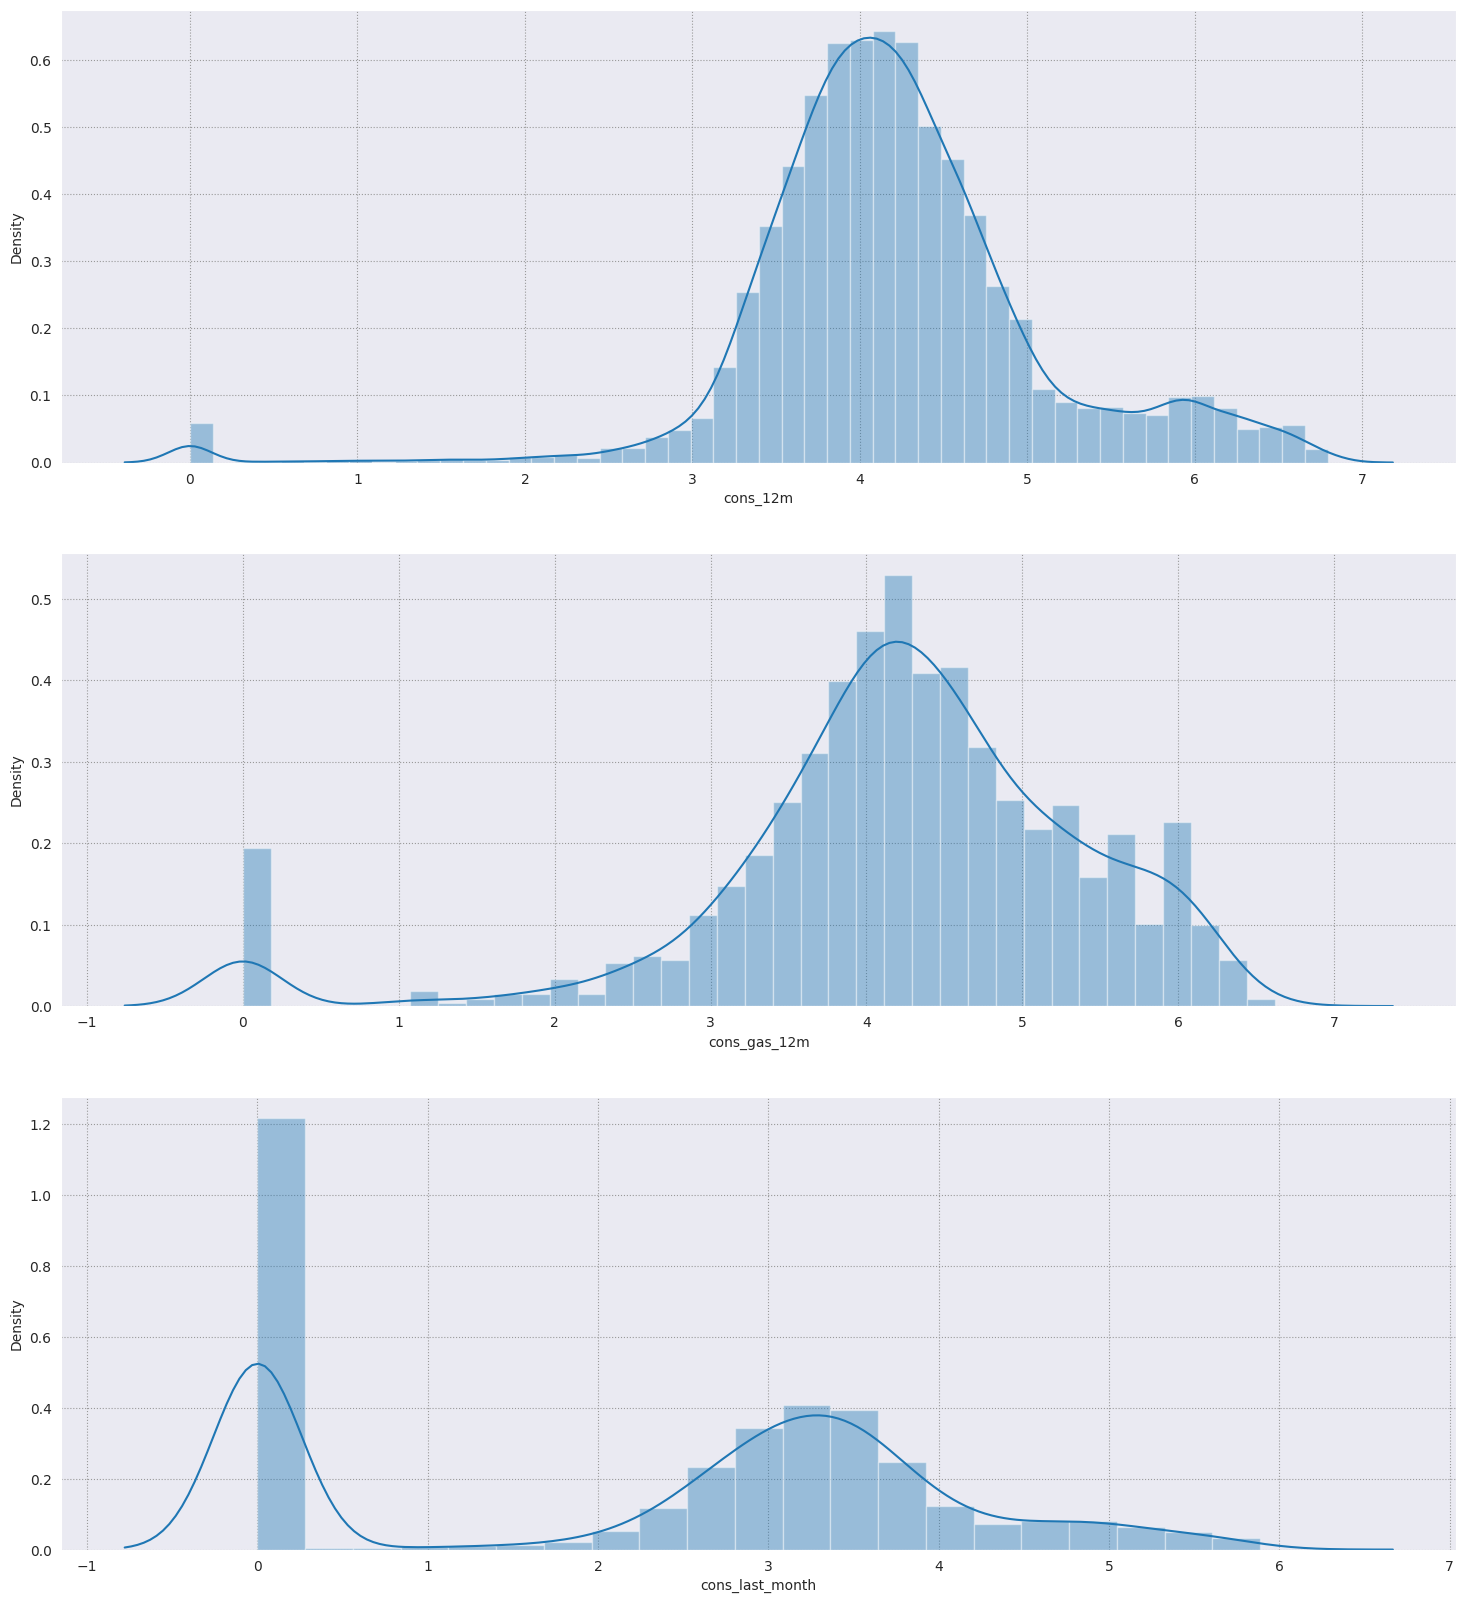

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

## Correlarions

In terms of creating new features and transforming existing ones, it is very much a trial and error situation that requires iteration. Once we train a predictive model we can see which features work and don't work, we will also know how predictive this set of features is. Based on this, we can come back to feature engineering to enhance our model.

For now, we will leave feature engineering at this point. Another thing that is always useful to look at is how correlated all of the features are within your dataset.

Reveal the linear relationships between features. Ideally, we want the features are highly correlated with churn, as this will indicate that they are good predictors of it. However, features that have a very high correlation can sometimes be suspisious. This is because two features having high correlation indicates that they may share a lot of the same information. **One of the assumptions of any parameteric predictive model is that all features must be independent**.

For features to be independent, each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, this breaks this assumption.

Ideally, we want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

So now let's look at how all the features within the model are correlated.



In [157]:
correlation = df.corr()

<ipython-input-157-bbce1ddb6927>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


In [158]:
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,mo_modif_prod,mo_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.000000,0.0,0.444045,0.114481,...,-5,-5,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.000000,0.0,1.237292,0.145711,...,-7,-7,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.000000,0.0,1.599009,0.165794,...,-3,-3,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.000000,0.0,1.318689,0.146694,...,-2,-2,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,2.721811,0.0,2.122969,0.116900,...,-2,-2,1,0,0,0,0,1,0,0


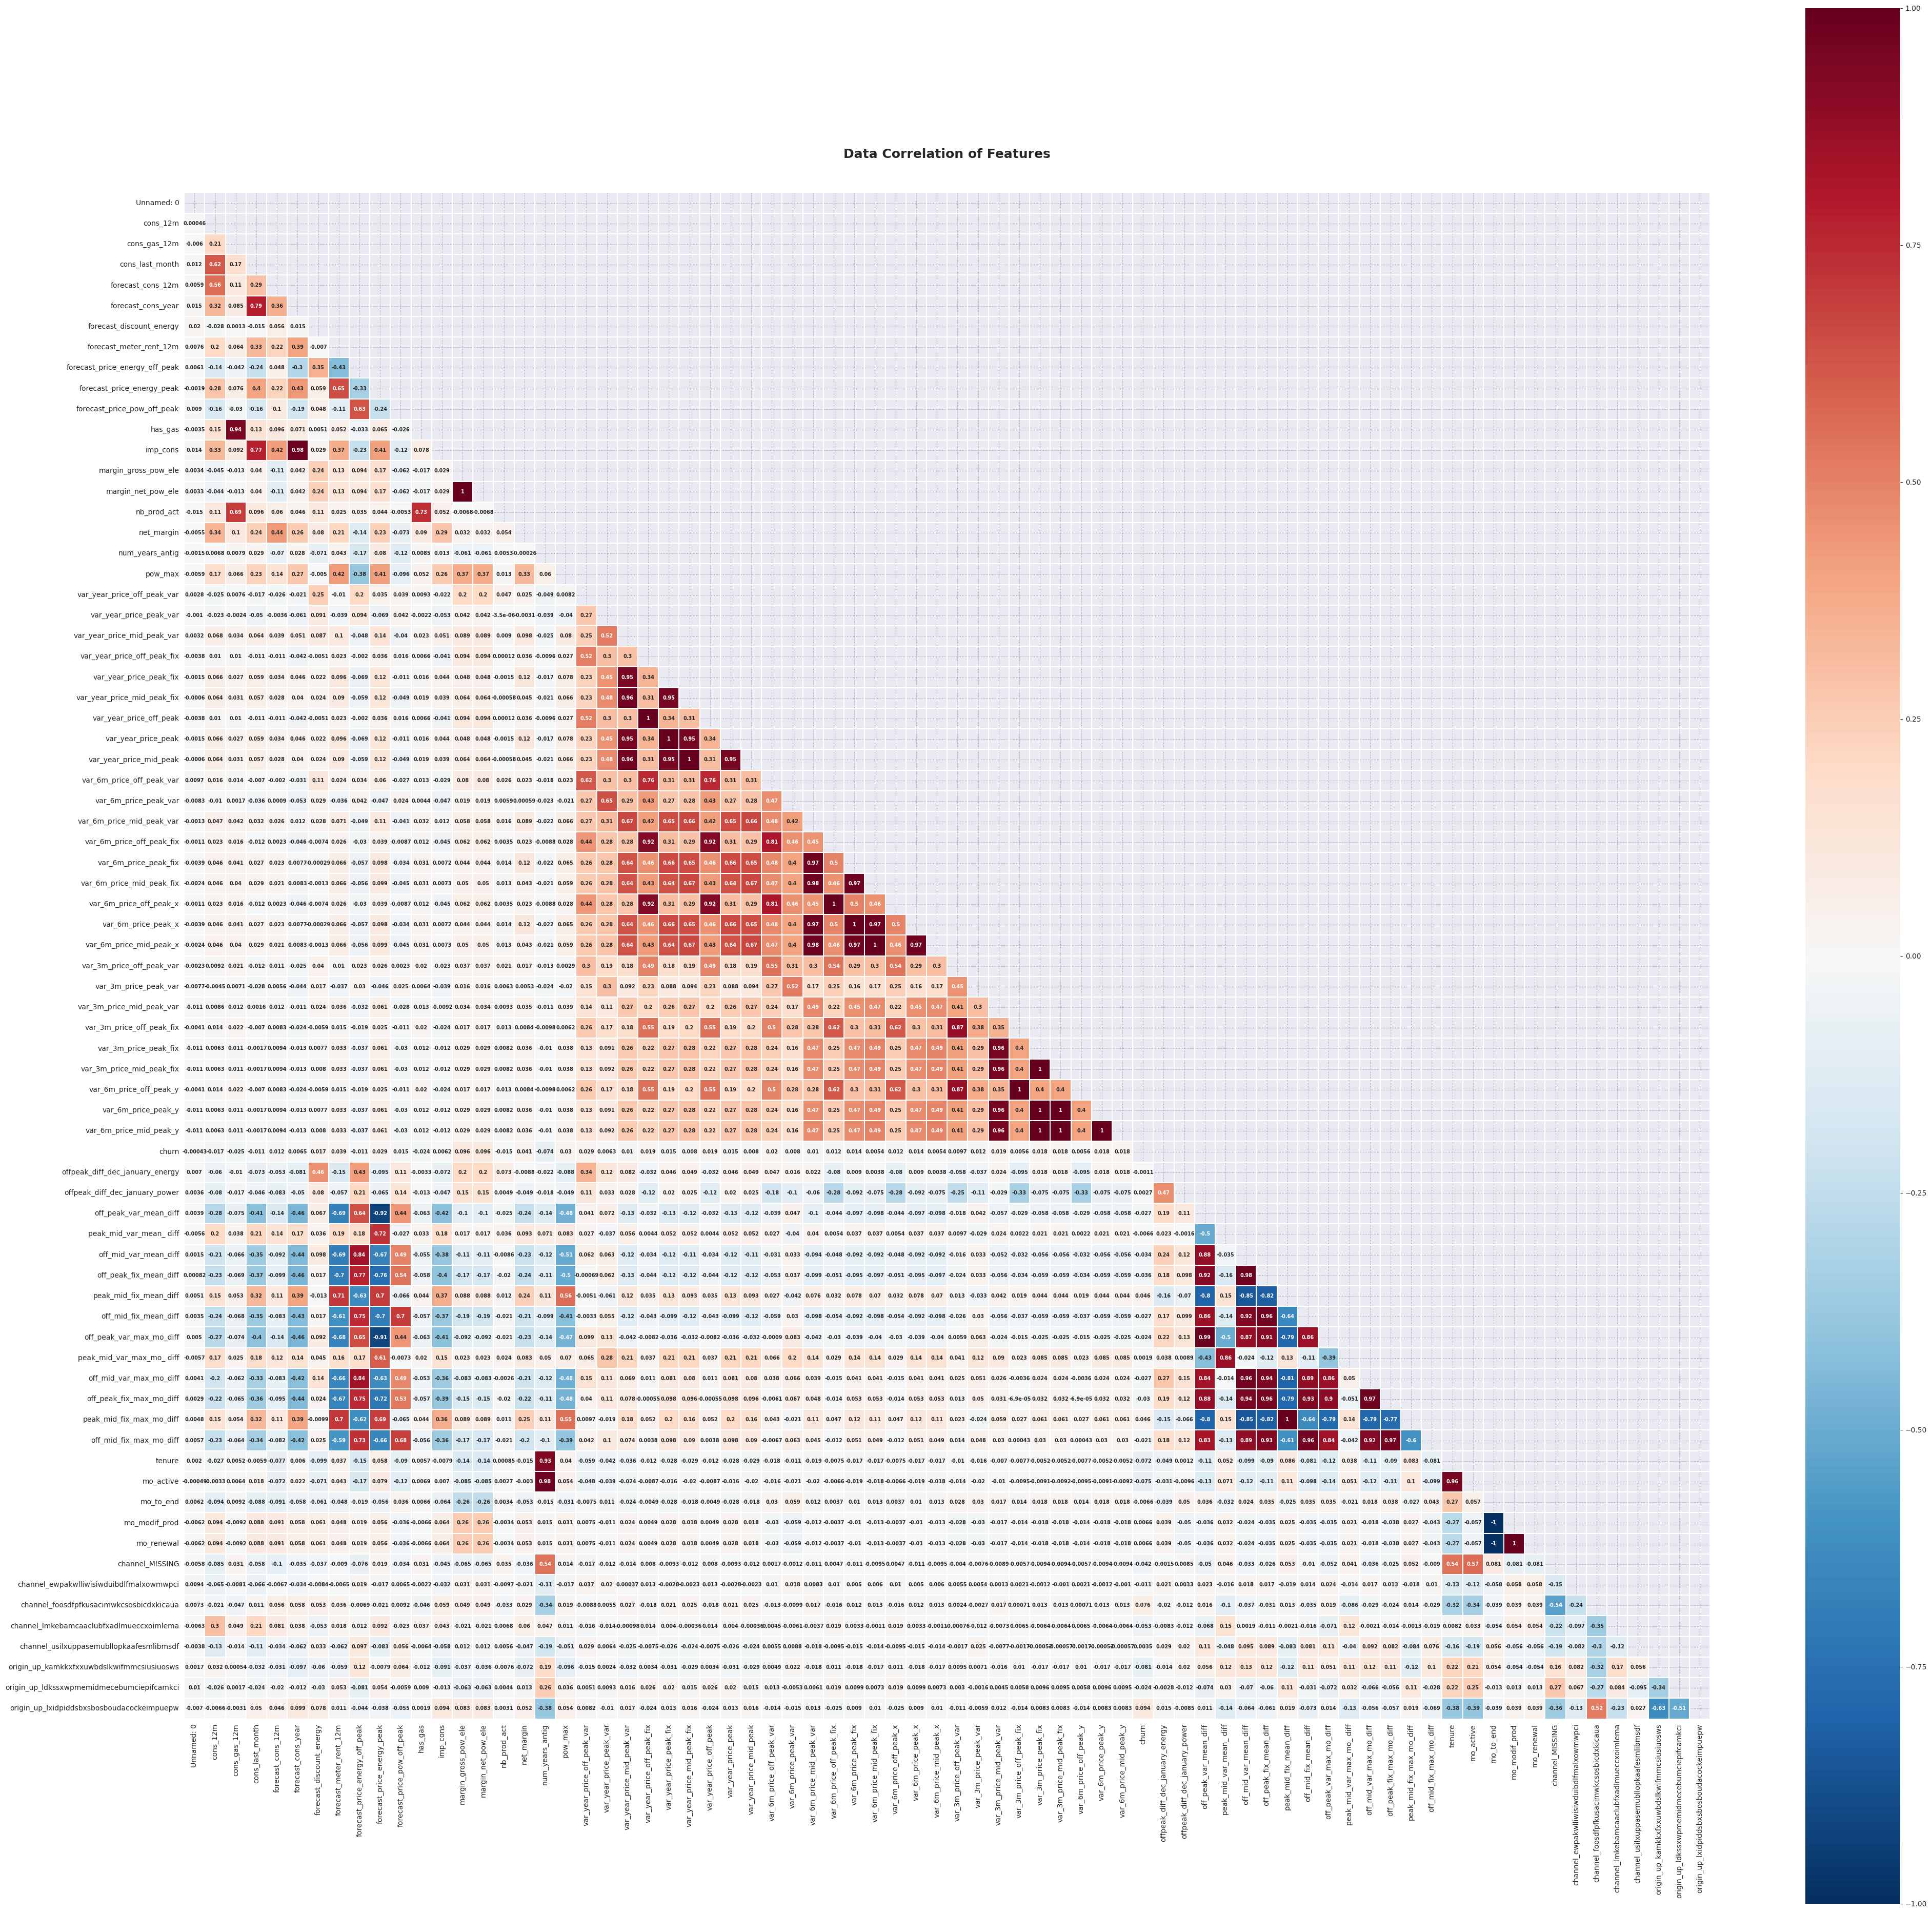

In [159]:
#plot the correlation
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(48, 48))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=18)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0,
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 7, "weight": "bold"},
                mask=mask)

plot_heatmap(df.select_dtypes(exclude='object'), title='Data')

In [160]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,mo_modif_prod,mo_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,...,-5,-5,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,...,-7,-7,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,...,-3,-3,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,...,-2,-2,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,...,-2,-2,1,0,0,0,0,1,0,0


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14604
Data columns (total 74 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  14605 non-null  int64  
 1   id                                          14605 non-null  object 
 2   cons_12m                                    14605 non-null  float64
 3   cons_gas_12m                                14605 non-null  float64
 4   cons_last_month                             14605 non-null  float64
 5   forecast_cons_12m                           14605 non-null  float64
 6   forecast_discount_energy                    14605 non-null  float64
 7   forecast_meter_rent_12m                     14605 non-null  float64
 8   forecast_price_energy_off_peak              14605 non-null  float64
 9   forecast_price_energy_peak                  14605 non-null  float64
 10  forecast_p

#Modeling

Now we have the engineered data, we're ready to start training the predictive model. We were required to focus on training a Random Forest classifier.

In [162]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Data Sampling
Split the dataset into training and testing dataset.

In [163]:
#make a copy of the preprocessed-data

train_df = df.copy()

#Separate target variable from independent features
y = df['churn']
X = df.drop(columns=['id','churn','price_date', 'Unnamed: 0'])

print(X.shape)
print(y.shape)

(14605, 70)
(14605,)


In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10953, 70)
(10953,)
(3652, 70)
(3652,)


## Model training

Once again, we are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm.

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging.

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [165]:
print(X_train.isnull().sum())

cons_12m                                      0
cons_gas_12m                                  0
cons_last_month                               0
forecast_cons_12m                             0
forecast_discount_energy                      0
                                             ..
channel_lmkebamcaaclubfxadlmueccxoimlema      0
channel_usilxuppasemubllopkaafesmlibmsdf      0
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws    0
origin_up_ldkssxwpmemidmecebumciepifcamkci    0
origin_up_lxidpiddsbxsbosboudacockeimpuepw    0
Length: 70, dtype: int64


In [129]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

## Evaluation

We are going to use 3 metrics to evaluate performance:

- Accuracy = the ratio of correctly predicted observations to the total observations
- Precision = the ability of the classifier to not label a negative sample as positive
- Recall = the ability of the classifier to find all the positive samples

In [166]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3652 entries, 4947 to 13784
Data columns (total 70 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   cons_12m                                    3652 non-null   float64
 1   cons_gas_12m                                3652 non-null   float64
 2   cons_last_month                             3652 non-null   float64
 3   forecast_cons_12m                           3652 non-null   float64
 4   forecast_discount_energy                    3652 non-null   float64
 5   forecast_meter_rent_12m                     3652 non-null   float64
 6   forecast_price_energy_off_peak              3652 non-null   float64
 7   forecast_price_energy_peak                  3652 non-null   float64
 8   forecast_price_pow_off_peak                 3652 non-null   float64
 9   has_gas                                     3652 non-null   int64  
 10  imp_cons

In [167]:
imputer = SimpleImputer(strategy='mean')
X_test = imputer.fit_transform(X_test)
pred = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()

In [168]:
y_test.value_counts()

0    3279
1     373
Name: churn, dtype: int64

In [169]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, pred)}")
print(f"Precision: {metrics.precision_score(y_test, pred)}")
print(f"Recall: {metrics.recall_score(y_test, pred)}")

True positives: 21
False positives: 2
True negatives: 3277
False negatives: 352

Accuracy: 0.9030668127053669
Precision: 0.9130434782608695
Recall: 0.05630026809651475


Looking at these results there are a few things to point out:

<b>Note:</b> If you are running this notebook yourself, you may get slightly different answers!

- Within the test set about 10% of the rows are churners (churn = 1).
- Looking at the true negatives, we have 3277 out of 3286. This means that out of all the negative cases (churn = 0), we predicted 3277 as negative (hence the name True negative). This is great!
- Looking at the false negatives, this is where we have predicted a client to not churn (churn = 0) when in fact they did churn (churn = 1). This number is quite high at 352, we want to get the false negatives to as close to 0 as we can, so this would need to be addressed when improving the model.
- Looking at false positives, this is where we have predicted a client to churn when they actually didnt churn. For this value we can see there are 2 cases, which is great!
- With the true positives, we can see that in total we have 373 clients that churned in the test dataset. However, we are only able to correctly identify 21 of those 373, which is very poor.
- Looking at the accuracy score, this is very **misleading**! Hence the use of precision and recall is important. The accuracy score is high, but it does not tell us the whole story.
- Looking at the precision score, this shows us a score of 0.91 which is not bad, but could be improved.
- However, the recall shows us that the classifier has a very poor ability to identify positive samples. This would be the main concern for improving this model!

So overall, we're able to very accurately identify clients that do not churn, but we are not able to predict cases where clients do churn! What we are seeing is that a high % of clients are being identified as not churning when they should be identified as churning. This in turn tells me that the current set of features are not discriminative enough to clearly distinguish between churners and non-churners.

A data scientist at this point would go back to feature engineering to try and create more predictive features. They may also experiment with optimising the parameters within the model to improve performance. For now, lets dive into understanding the model a little more.

## Model understanding

A simple way of understanding the results of a model is to look at feature importances. Feature importances indicate the importance of a feature within the predictive model, there are several ways to calculate feature importance, but with the Random Forest classifier, we're able to extract feature importances using the built-in method on the trained model. In the Random Forest case, the feature importance represents the number of times each feature is used for splitting across all trees.

In [170]:
# Convert the NumPy array to a DataFrame
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Assuming 'model' is your trained random forest model
feature_importances = pd.DataFrame({
    'features': X_train_df.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index(drop=True)

In [173]:
# X.columns.tolist()

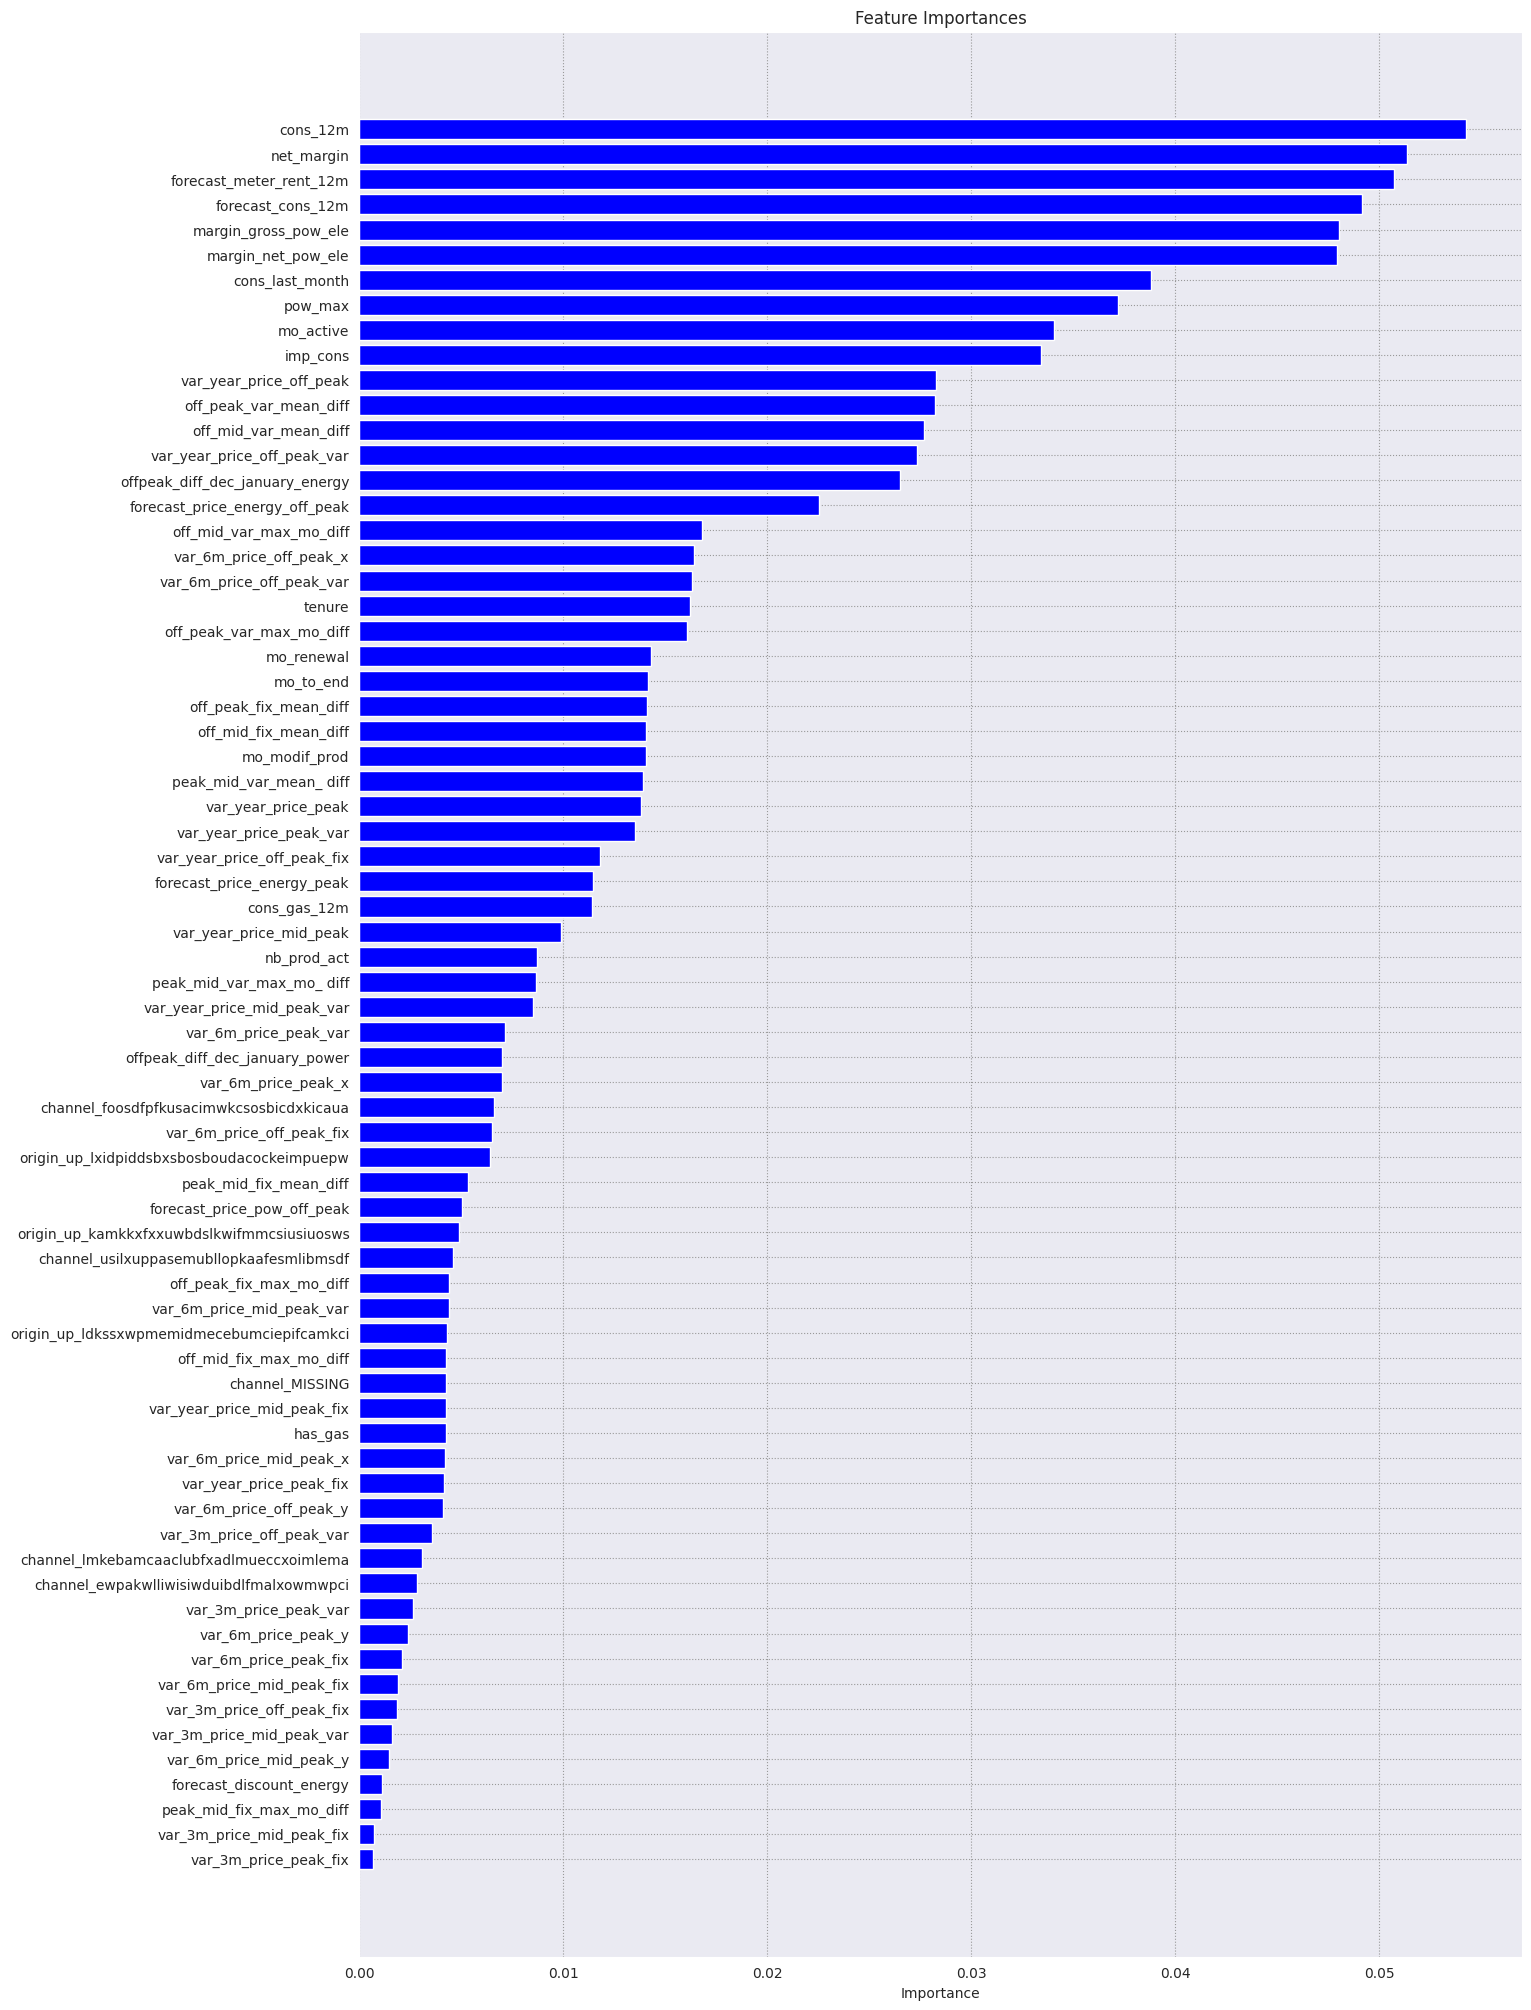

In [174]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

From this chart, we can observe the following points:

- Net margin and consumption over 12 months is a top driver for churn in this model
- Margin on power subscription also is an influential driver
- Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract
- The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it
- Our price sensitivity features are scattered around but are not the main driver for a customer churning

The last observation is important because this relates back to our original hypothesis:

    > Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

In [175]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [181]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,mo_modif_prod,mo_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,5.705621,0.000000,4.715176,0.000000,0.0,2.166341,0.120372,0.103487,40.606701,0.0,...,-12.0,-12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,6.000648,5.203623,5.050759,2.818932,0.0,1.312177,0.144902,0.000000,44.311378,1.0,...,-4.0,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0,2.125774,0.092453,0.086393,59.173468,0.0,...,-11.0,-11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.345433,0.000000,0.000000,3.516690,0.0,1.304921,0.142996,0.000000,44.311378,0.0,...,-1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.201943,0.000000,2.484300,2.523109,0.0,1.238548,0.141434,0.000000,44.311378,0.0,...,-8.0,-8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [182]:
# Convert the NumPy array to a DataFrame
# X_test_df = pd.DataFrame(X_test, columns=X.columns)


In [183]:
X_test_df['churn'] = pred.tolist()
X_test_df['churn_probability'] = probabilities.tolist()
X_test_df.to_csv('out_of_sample_data_with_predictions.csv')